# Segmentação de imagens Sentinel-2/MSI para a identificação de campos de mineração

Este notebook apresenta os passos seguidos durante o desenvolvimento do trabalho da matéria de **Inteligência artificial** da Fatec SJC

O grupo que desenvolve este projeto é formado pelos seguintes alunos:
 - Carlos Neto;
 - Felipe Menino;
 - Mauricio Kyoshi;
 - Weslei Luiz.

In [ ]:
import numpy as np
import functions.utils as uts
import functions.plots as fplt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from functions.clusters import mkmeans

### Carregando a imagem utilizada na clusterização

In [ ]:
IMAGE_TRAIN_PATH = """
/home/enz/Imagens/2_imagens_satelites/1_imagens_sentinel/1_trabalho_ia/1_treino/S2B_MSIL1C_20181017T141049_N0206_R110_T21MWU_20181017T173622.SAFE/GRANULE/L1C_T21MWU_A008430_20181017T141043/IMG_DATA/COMPOSICAO_B843_RECORTE.tif
""".strip()

IMAGE_TEST_PATH = """
/home/enz/Imagens/2_imagens_satelites/1_imagens_sentinel/1_trabalho_ia/2_teste/S2A_MSIL1C_20170720T134211_N0205_R124_T22MGD_20170720T134211.SAFE/GRANULE/L1C_T22MGD_A010846_20170720T134211/IMG_DATA/L1C_T22MGD_A010846_20170720T134211_B843_RECORTE.tif
""".strip()

# Imagens para geração do scatter plot
IMAGES_SCATTER = [
    "/home/enz/Imagens/2_imagens_satelites/1_imagens_sentinel/1_trabalho_ia/2_teste/S2A_MSIL1C_20170720T134211_N0205_R124_T22MGD_20170720T134211.SAFE/GRANULE/L1C_T22MGD_A010846_20170720T134211/IMG_DATA/recortes_para_validacao/REGIOES_DE_VALIDACAO/MINERACAO_1.tif",
    "/home/enz/Imagens/2_imagens_satelites/1_imagens_sentinel/1_trabalho_ia/2_teste/S2A_MSIL1C_20170720T134211_N0205_R124_T22MGD_20170720T134211.SAFE/GRANULE/L1C_T22MGD_A010846_20170720T134211/IMG_DATA/recortes_para_validacao/REGIOES_DE_VALIDACAO/MINERACAO_2.tif",
    "/home/enz/Imagens/2_imagens_satelites/1_imagens_sentinel/1_trabalho_ia/2_teste/S2A_MSIL1C_20170720T134211_N0205_R124_T22MGD_20170720T134211.SAFE/GRANULE/L1C_T22MGD_A010846_20170720T134211/IMG_DATA/recortes_para_validacao/REGIOES_DE_VALIDACAO/GERAL_1.tif"
]

RANDOM_STATE = 45

In [3]:
dimage = uts.load_stacked_image(IMAGE_TRAIN_PATH, 3)
timage = uts.load_stacked_image(IMAGE_TEST_PATH, 3)

In [4]:
simages = [uts.load_stacked_image(i, 3) for i in IMAGES_SCATTER]

## Identificação do melhor K

Nesta primeira bateria de testes 3 clusterizações serão realizadas variando a quantidade do `K` , isto para permitir utilizar o método de `Elbow` e definir qual o melhor `K` a ser utilizado.


In [5]:
K_S = 2

k_values = list(range(2, K_S + 3)); K_S_LEN = len(k_values)
tols = np.repeat(1e-4, K_S_LEN).tolist()
n_inits = np.repeat(10, K_S_LEN).tolist()
max_iters = np.repeat(300, K_S_LEN).tolist()
initializers = np.repeat("k-means++", K_S_LEN).tolist()

Veja que, os valores definidos acima serão utilizados como parâmetros para a instância do KMeans, do pacote `SKLearn`. É interessante notar que, o interesse neste primeiro teste é identificar um valor de `K` bom para o escopo deste problema, sendo assim, os valores passados nas listas são padrões da biblioteca `SKLearn` para a instância do KMeans.

Outro ponto interessante a ser notado é que, o valor mínimo de `K` é 3, isto foi definido como um requisito mínimo, para que, além da mineração, outras feições da imagem possam ser identificadas.

Dito isto, façamos a execução deste primeiro conjunto de clusterizações para a identificação do melhor `K`.

In [6]:
t1_models = mkmeans(dimage["reshaped_image"], initializers, k_values, tols, max_iters, n_inits)

Com cada um dos modelo gerados, façamos a visualização do parâmetro de `Elbow` para definir a quantidade ideal de clusters

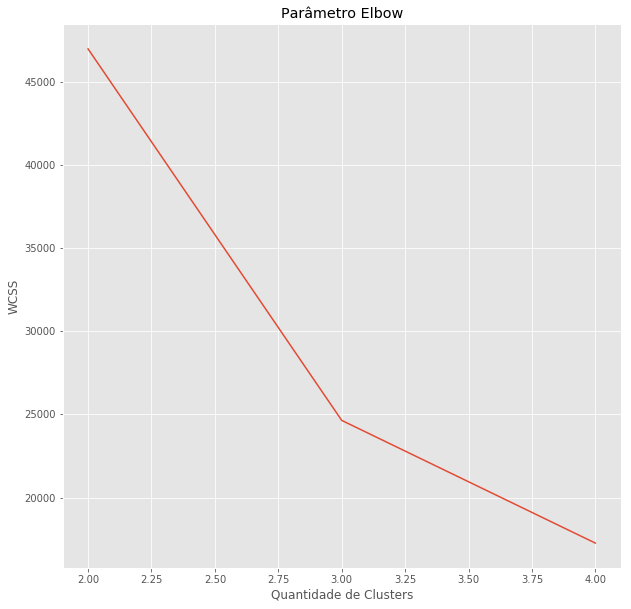

In [7]:
fplt.plot_elbow(t1_models)

De acordo com a métrica de `Elbow` a quantidade ideal de `K` para o escopo deste problema é 4, já que é ele que não apresenta uma discrepância muito grande na variância.

Com esta definição feita, testes serão criados para definir a melhor combinação de parâmetros para este escopo, aqui os parâmetros que serão avaliados e testados são:

- Forma de inicialização;
- Tolerância relativa para declarar convergência;
- Quantidade máxima de iterações;
- Número máximo de definições dos centroids;
- Método de distância.

## Variação dos parâmetros

Como citado anteriormente, agora serão feitas variações nos parâmetros do KMeans para definir qual a melhor combinação de parâmetros para o escopo. É interessante ressaltar que, as possibilidades de combinações e mudanças são infinitas, por isto, neste trabalho 10 combinações serão consideradas.


In [5]:
K = 3

### Modelos (1, 2, 3) - MRNI_1, MRNI_2, MRNI_3 

Neste modelo a forma de inicialização e a quantidade de mudanças dos centroids serão limitados para verificação do comportamento.

In [9]:
mrni_1 = KMeans(n_clusters=K, init="random", random_state=RANDOM_STATE, n_init=5)
mrni_1 = mrni_1.fit(dimage["reshaped_image"])

In [10]:
mrni_2 = KMeans(n_clusters=K, init="random", random_state=RANDOM_STATE, n_init=3)
mrni_2 = mrni_2.fit(dimage["reshaped_image"])

In [11]:
mrni_3 = KMeans(n_clusters=K, init="random", random_state=RANDOM_STATE + 10, n_init=3)
mrni_3 = mrni_3.fit(dimage["reshaped_image"])

Com os modelos gerados, vejamos qual é a menor `inertia` entre os modelos gerados.

In [12]:
uts.print_models_inertia({
    "mrni_1": mrni_1,
    "mrni_2": mrni_2,
    "mrni_3": mrni_3
})

mrni_1 - 24638.60314329359
mrni_2 - 24638.606908256
mrni_3 - 24638.602808726686


#### Plot MRNI_1


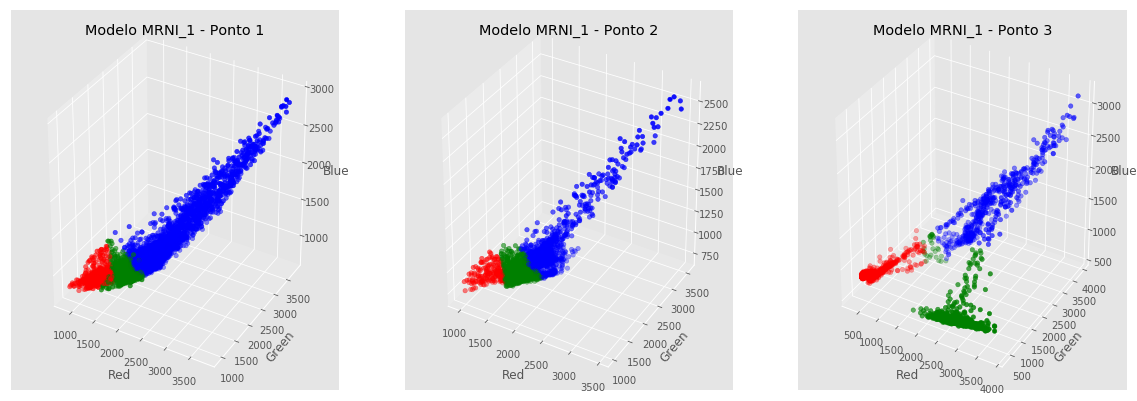

In [13]:
fplt.scatter3(mrni_1, "Modelo MRNI_1", simages, ["red", "green", "blue"])

#### Plot MRNI_2

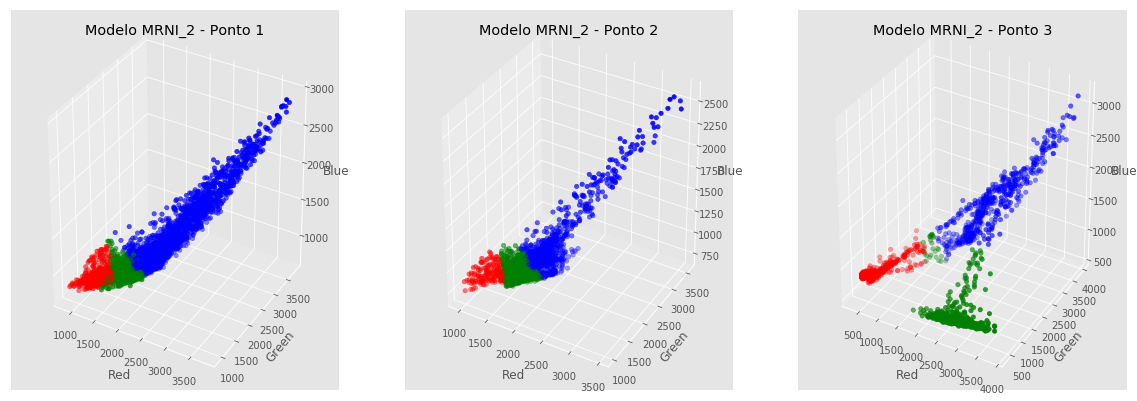

In [14]:
fplt.scatter3(mrni_2, "Modelo MRNI_2", simages, ["red", "blue", "green"])

#### Plot MRNI_3

Por fim, nesta primeira bateria de testes, o último modelo (MRNI_3) é apresentado, também não criando muitos problemas relacionados a separação dos dados.

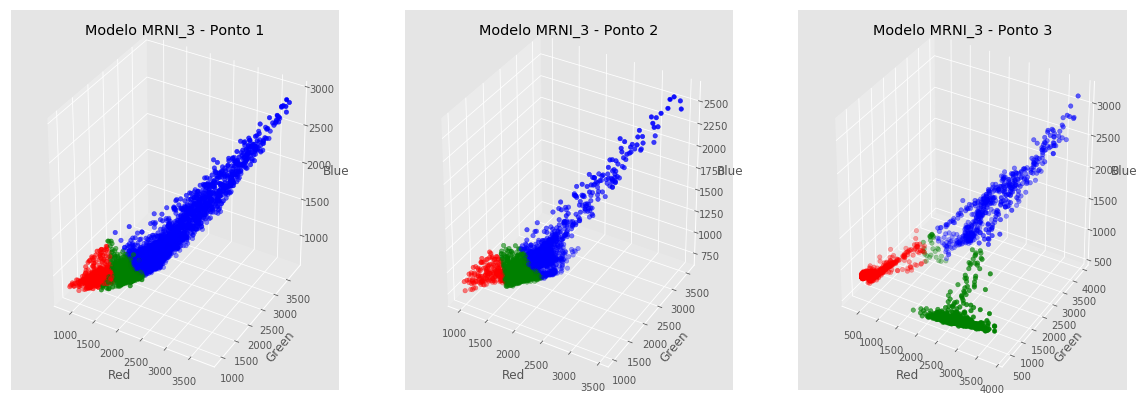

In [15]:
fplt.scatter3(mrni_3, "Modelo MRNI_3", simages, ["blue", "green", "red"])

### Modelos (4, 5) - MMIT_1, MMIT_2 

Nestes testes serão gerados clusters KMeans variando a quantidade máxima de iterações e a tolerância para a generalização.

In [11]:
mmit_1 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=100, tol=22000)
mmit_1 = mmit_1.fit(dimage["reshaped_image"])

In [9]:
mmit_2 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=20, tol=0.99)
mmit_2 = mmit_2.fit(dimage["reshaped_image"])

In [13]:
uts.print_models_inertia({
    "mmit_1": mmit_1,
    "mmit_2": mmit_2
})

mmit_1 - 24638.729568901264
mmit_2 - 24638.599819788622


#### Plot MMIT_1

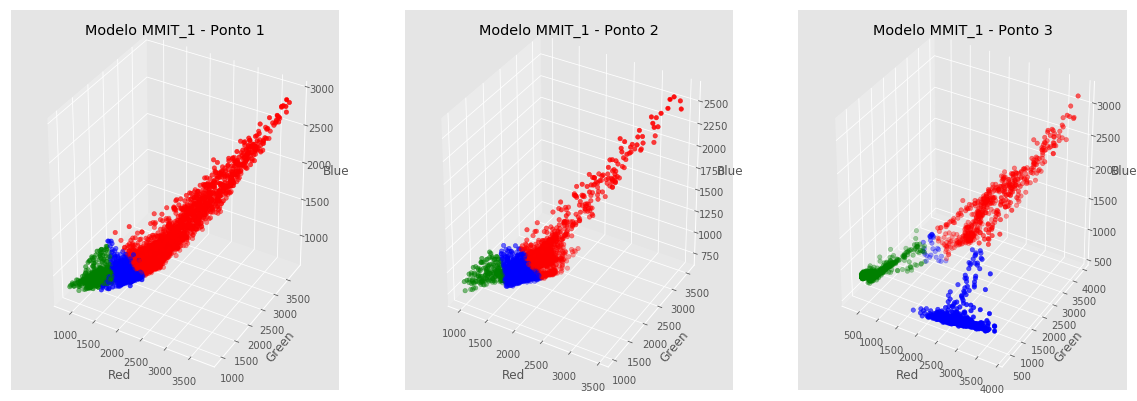

In [14]:
fplt.scatter3(mmit_1, "Modelo MMIT_1", simages, ["blue", "green", "red"])

#### Plot MMIT_2

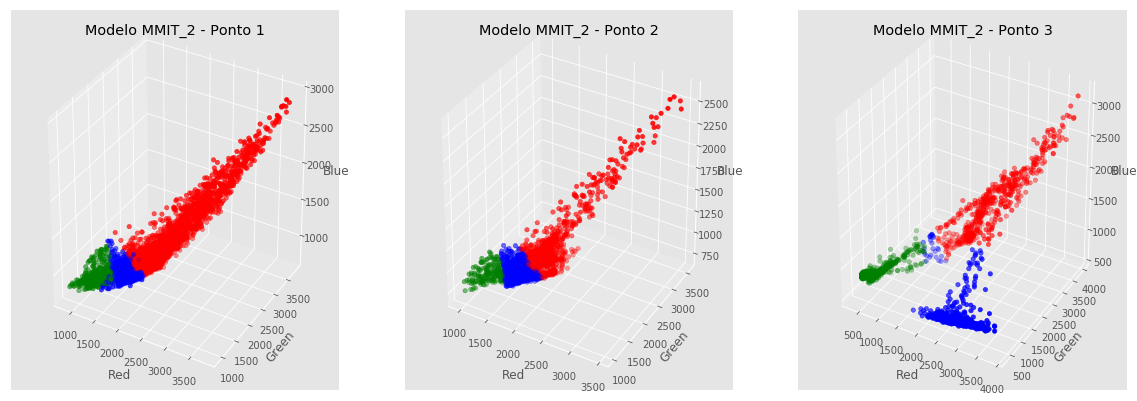

In [20]:
fplt.scatter3(mmit_2, "Modelo MMIT_2", simages, ["blue", "green", "red"])

### Modelos (6, 7) - MMNI_1, MMNI_2 

- MAX_ITERATION;
- N_INIT

In [21]:
mmni_1 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=100, n_init=3)
mmni_1 = mmni_1.fit(dimage["reshaped_image"])

In [22]:
mmni_2 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=4, n_init=1)
mmni_2 = mmni_2.fit(dimage["reshaped_image"])

In [23]:
uts.print_models_inertia({
    "mmni_1": mmni_1,
    "mmni_2": mmni_2
})

mmni_1 - 24638.599819788622
mmni_2 - 24638.599819788622


#### Plot MMNI_1

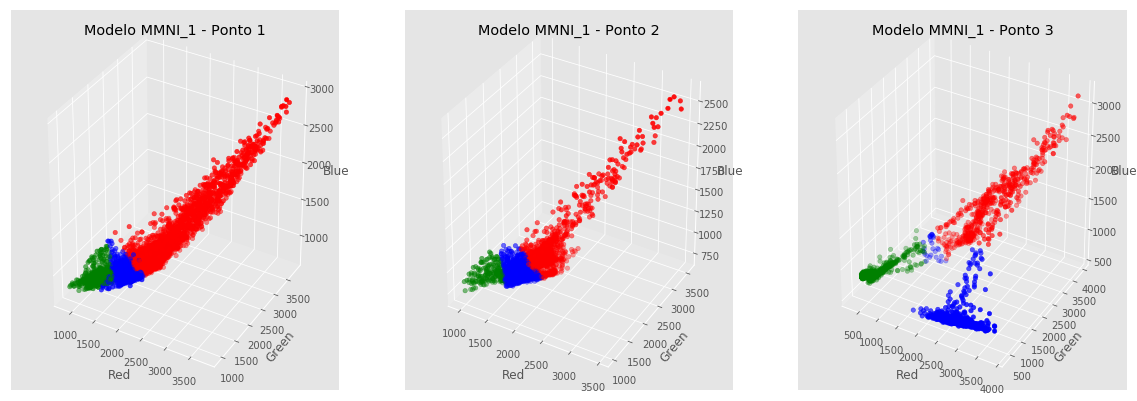

In [24]:
fplt.scatter3(mmni_1, "Modelo MMNI_1", simages, ["blue", "green", "red"])

#### Plot MMNI_2

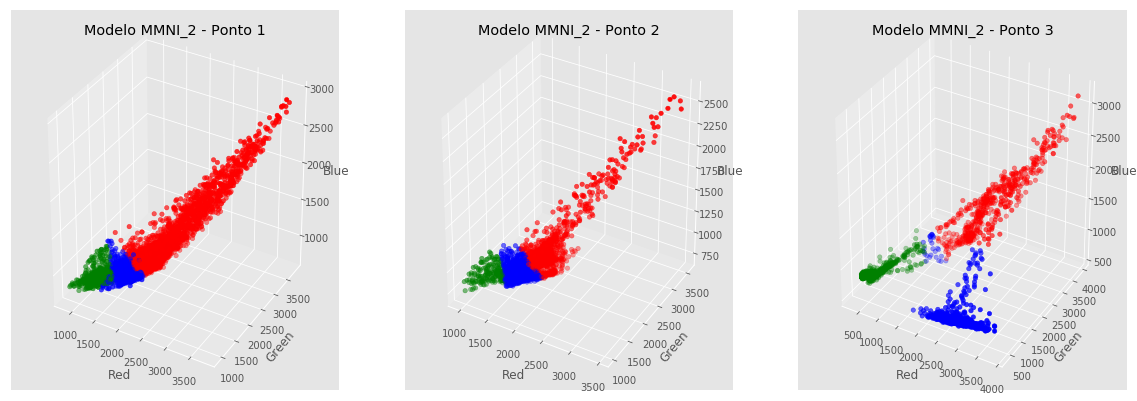

In [25]:
fplt.scatter3(mmni_2, "Modelo MMNI_2", simages, ["blue", "green", "red"])

### Modelos (8, 9) - MMNIT_1, MMNIT_2

- MAX ITERATION;
- NINIT;
- TOL

In [6]:
mmnit_1 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=16, n_init=2, tol=0.9)
mmnit_1 = mmnit_1.fit(dimage["reshaped_image"])

In [7]:
mmnit_2 = KMeans(n_clusters=K, init="k-means++", random_state=RANDOM_STATE, max_iter=2, n_init=7, tol=20000)
mmnit_2 = mmnit_2.fit(dimage["reshaped_image"])

In [8]:
uts.print_models_inertia({
    "mmnit_1": mmnit_1,
    "mmnit_2": mmnit_2
})

mmnit_1 - 24638.599819788622
mmnit_2 - 24638.729568901264


#### Plot MMNIT_1

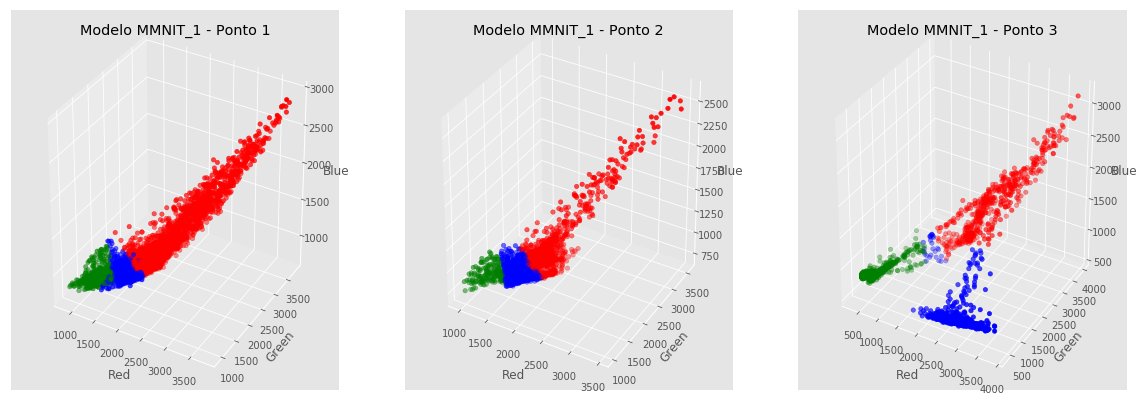

In [29]:
fplt.scatter3(mmnit_1, "Modelo MMNIT_1", simages, ["blue", "green", "red"])

#### Plot MMNIT_2

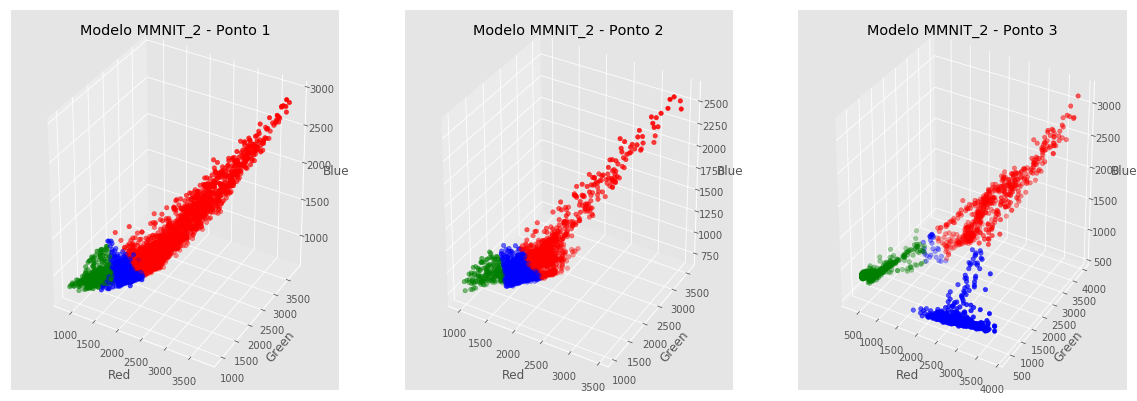

In [9]:
fplt.scatter3(mmnit_2, "Modelo MMNIT_2", simages, ["blue", "green", "red"])

### Modelos (10) - MMINTI_1

- MAX_ITERATION;
- N_INIT;
- TOL;
- INICIALIZACAO

In [31]:
mminti_1 = KMeans(n_clusters=K, init="random", random_state=RANDOM_STATE, max_iter=50, n_init=2, tol=1e-1)
mminti_1 = mminti_1.fit(dimage["reshaped_image"])

In [32]:
uts.print_models_inertia({
    "mminti_1": mminti_1
})

mminti_1 - 24639.831623157825


#### Plot MMINTI_1

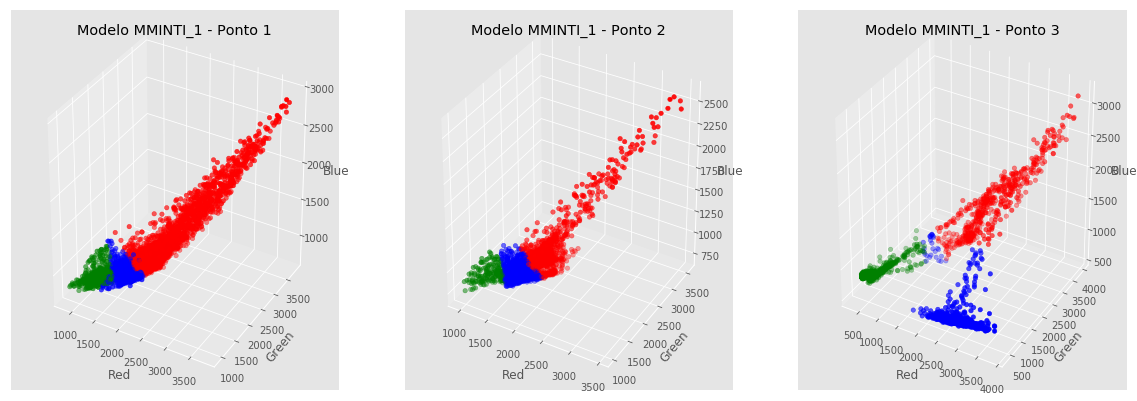

In [33]:
fplt.scatter3(mmnit_1, "Modelo MMINTI_1", simages, ["blue", "green", "red"])

### Salvando o melhor modelo (Menor WCSS)

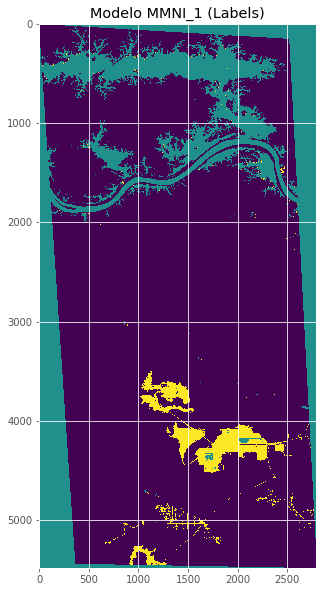

In [34]:
fplt.kmeans_in_image(dimage["original_image"], mmni_1, "Modelo MMNI_1 (Labels)")

In [35]:
uts.write_georef_labels(IMAGE_TRAIN_PATH, "./results/mmni_1_labels.TIF", mmni_1.labels_.reshape(dimage["original_image"].shape[0:2]))

### Salvando o melhor modelo

Para possibilitar a utilização do melhor modelo gerado, ele será serializado.

In [36]:
import _pickle as cPickle

with open('results/model_mmni_1.pkl', 'wb') as fid:
    cPickle.dump(mmni_1, fid)